In [ ]:
# Final Project

In [ ]:
## CNN + LSTM

# Team Number 3

In [20]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle # storing numpy features
from keras.models import load_model


plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [21]:
pwd

'/Users/chaitanya/anaconda3/DSME_Final_Project'

In [22]:
image_path = '/Users/chaitanya/anaconda3/DSME_Final_Project/Images'

In [23]:
data = pd.read_csv("/Users/chaitanya/anaconda3/DSME_Final_Project/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [24]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/Users/chaitanya/anaconda3/DSME_Final_Project/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

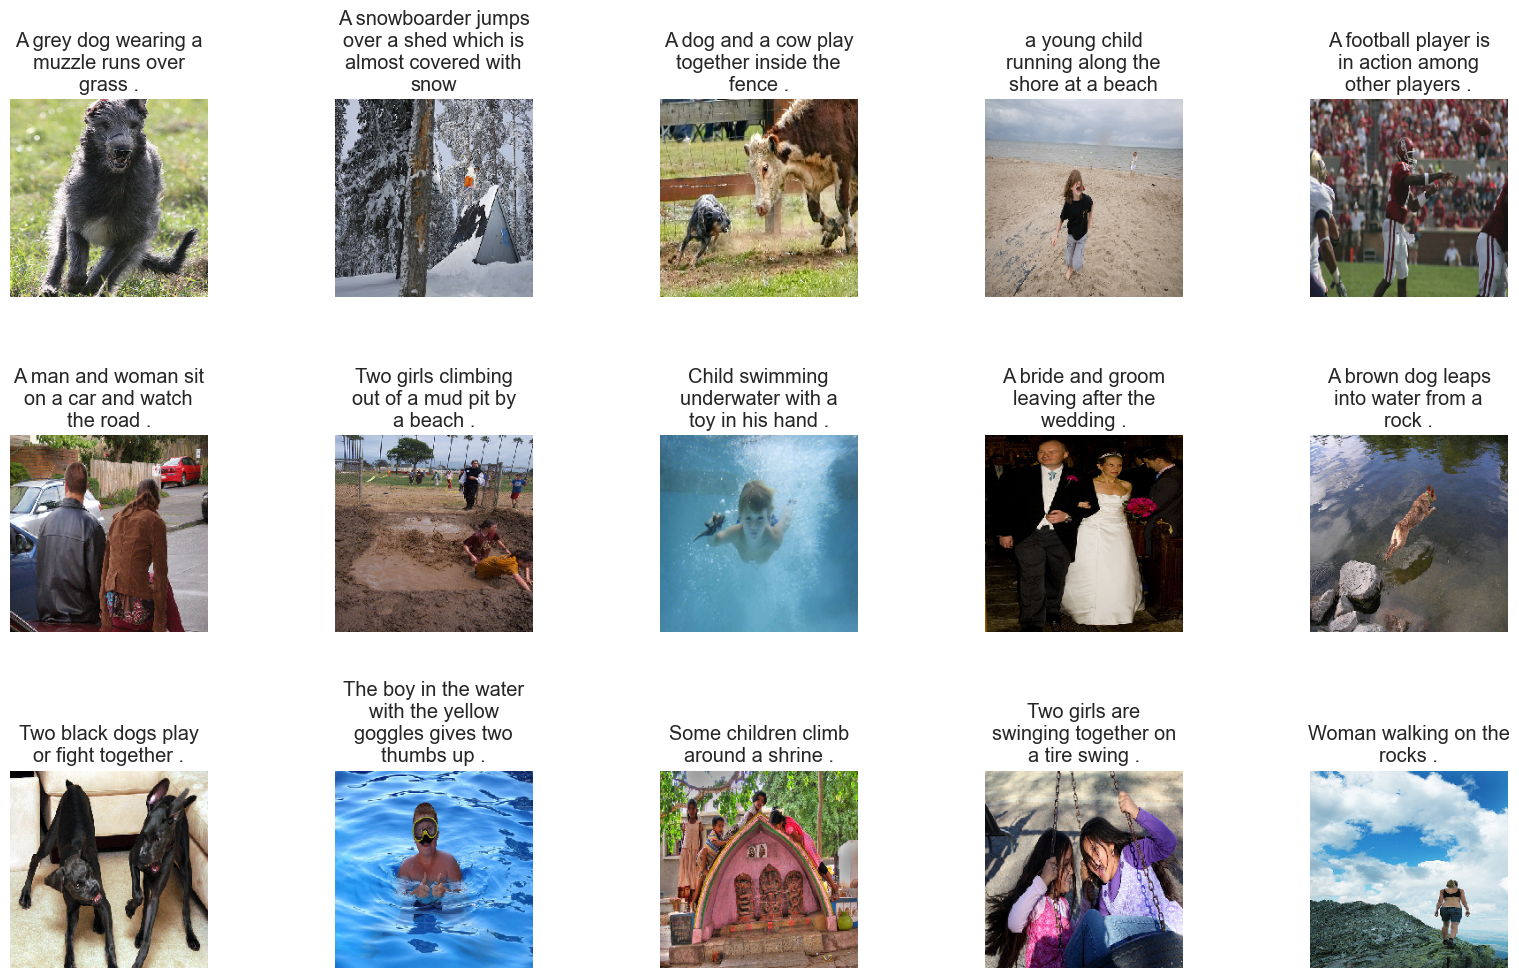

In [25]:
display_images(data.sample(15))

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [12]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [38:20<00:00,  3.52it/s]  


In [14]:
# store features in pickle
pickle.dump(features, open(os.path.join('/Users/chaitanya/anaconda3/DSME_Final_Project/', 'features_DenseNet.pkl'), 'wb'))

In [10]:
# load features from pickle
with open(os.path.join('/Users/chaitanya/anaconda3/DSME_Final_Project/', 'features_DenseNet.pkl'), 'rb') as f:
    features = pickle.load(f)

In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [12]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)


sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

2023-04-25 14:30:41.861431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from tensorflow.keras.utils import plot_model

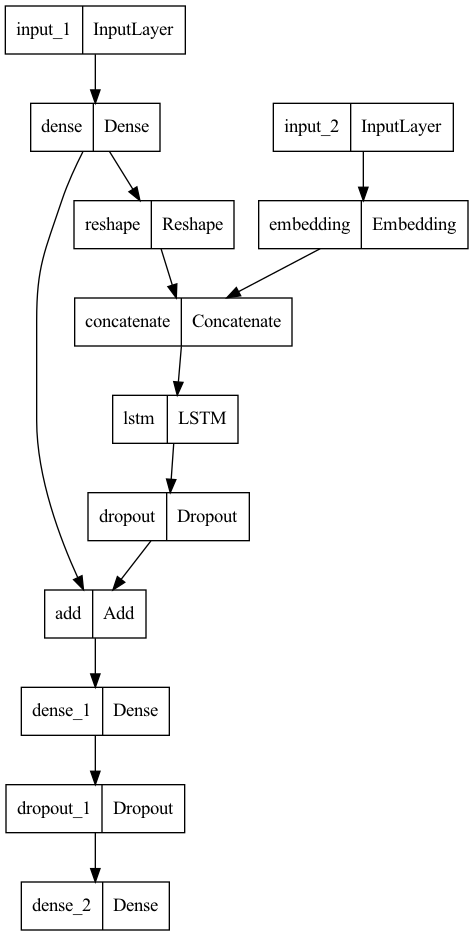

In [17]:
plot_model(caption_model)

In [15]:
caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                              

In [24]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [25]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [26]:
saved_LSTM_model = load_model('/Users/chaitanya/anaconda3/DSME_Final_Project/model.h5')


In [43]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 4.6102
Epoch 1: val_loss improved from inf to 4.09999, saving model to model.h5
537/537 [==============================] - 4241s 8s/step - loss: 4.6102 - val_loss: 4.1000 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.0827
Epoch 2: val_loss improved from 4.09999 to 3.86805, saving model to model.h5
537/537 [==============================] - 545s 1s/step - loss: 4.0827 - val_loss: 3.8681 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.8668
Epoch 3: val_loss improved from 3.86805 to 3.74548, saving model to model.h5
537/537 [==============================] - 351s 654ms/step - loss: 3.8668 - val_loss: 3.7455 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7242
Epoch 4: val_loss improved from 3.74548 to 3.68832, saving model to model.h5
537/537 [==============================] - 710s 1s/step - loss: 3.7242 - va

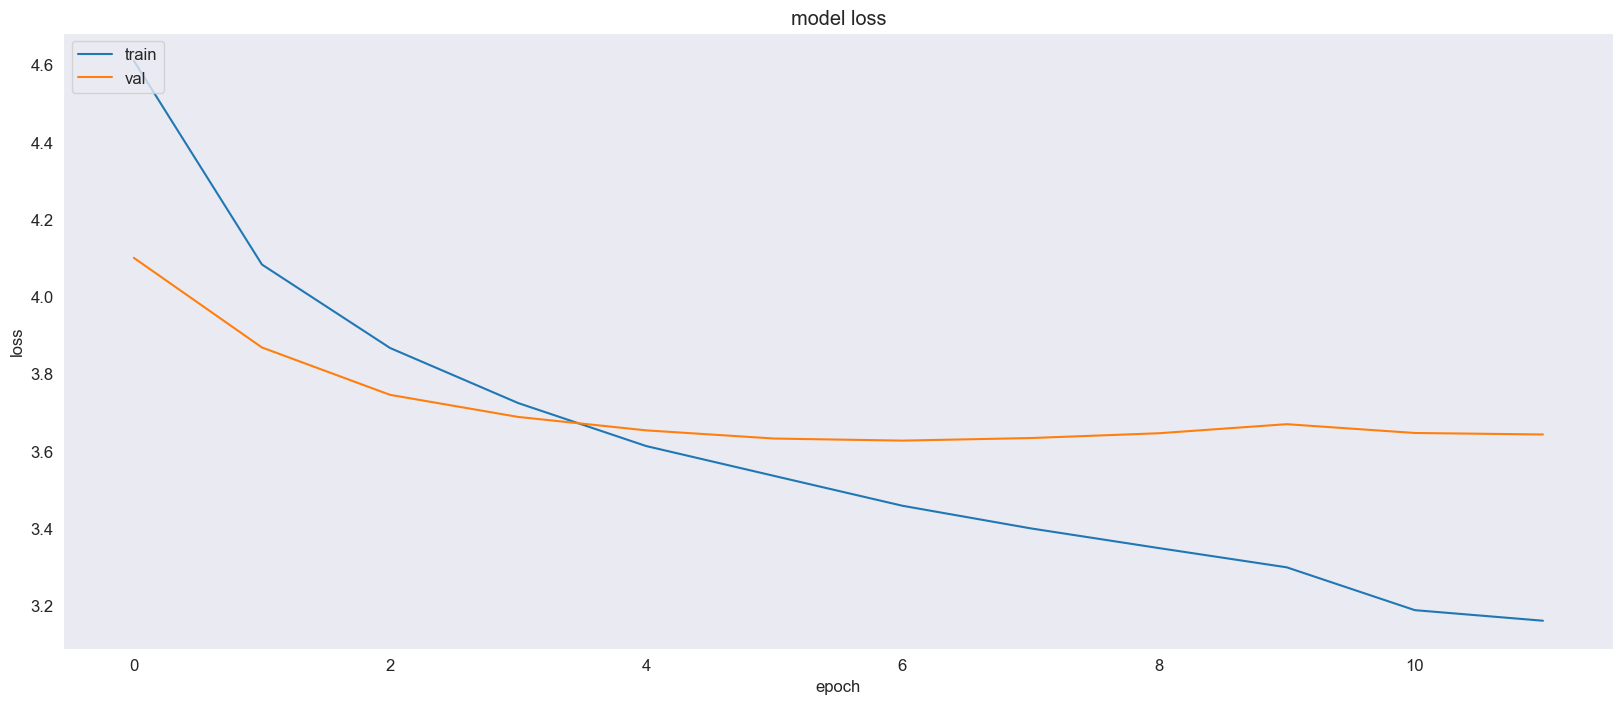

In [44]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [46]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [47]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [48]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 25ms/step


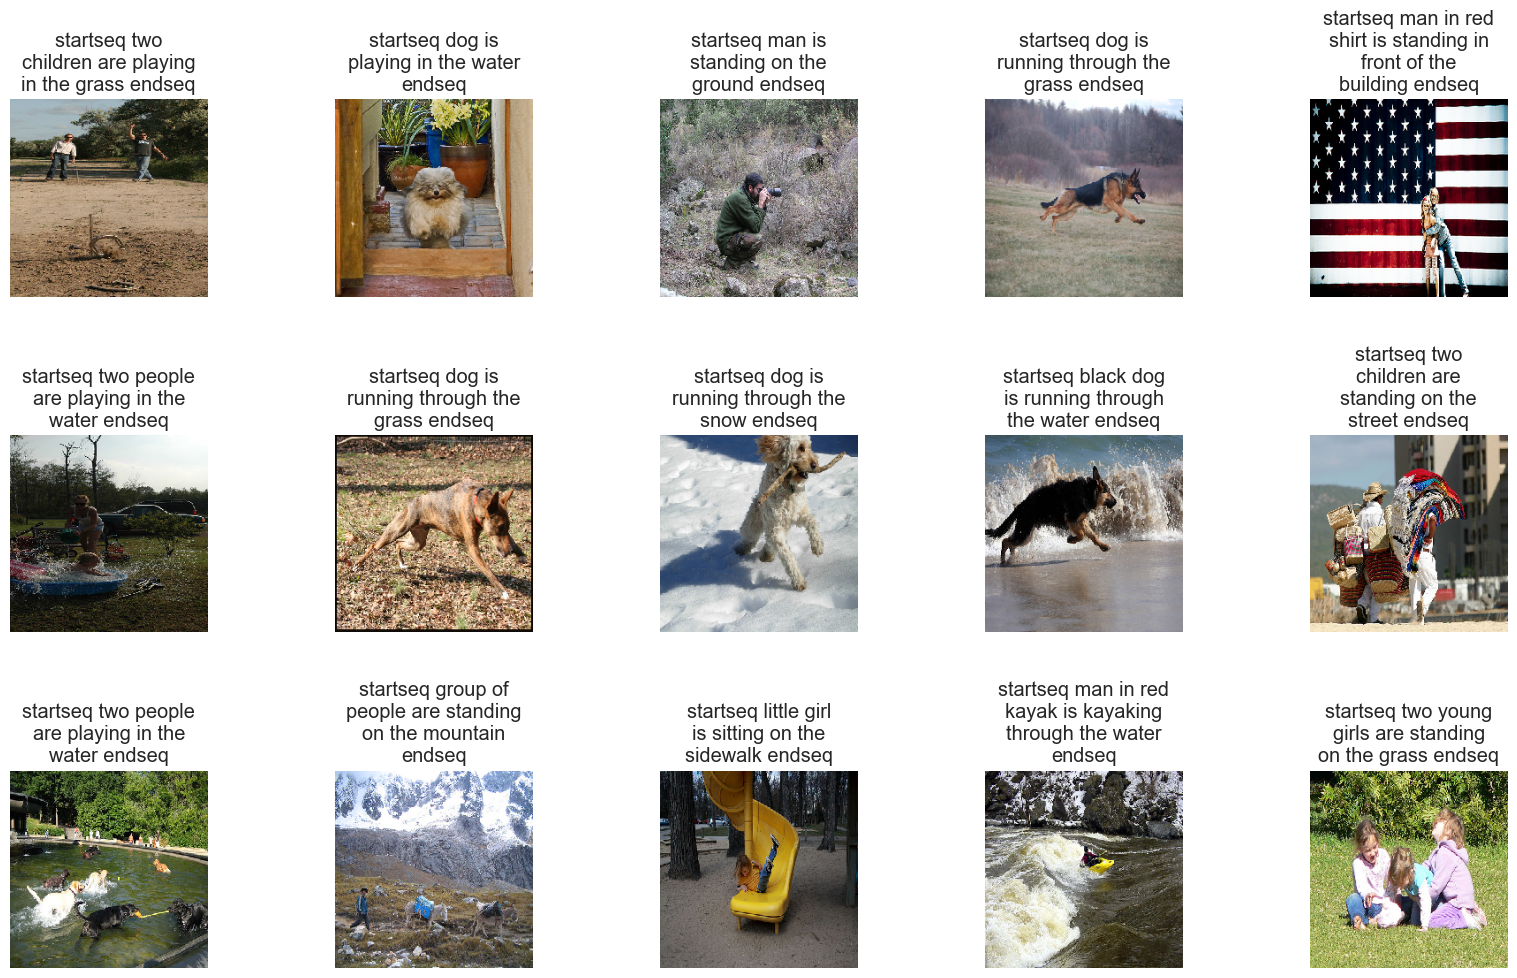

In [50]:
display_images(samples)


In [61]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# ... existing code ...

def calculate_bleu_score(reference, candidate):
    # Tokenize reference and candidate sentences
    ref_tokens = nltk.word_tokenize(reference.lower())
    can_tokens = nltk.word_tokenize(candidate.lower())

    # Calculate BLEU score
    weights = (0.25, 0.25, 0.25, 0.25)
    bleu_score = sentence_bleu([ref_tokens], can_tokens, weights=weights)

    return bleu_score

# ... existing code ...

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption'] = caption

    reference = record['caption']
    candidate = caption.replace('startseq', '').replace('endseq', '').strip()  # Remove startseq, endseq and extra spaces
    bleu_score = calculate_bleu_score(reference, candidate)
    samples.loc[index, 'bleu_score'] = bleu_score

# Mean BLEU score across all samples
mean_bleu_score = samples['bleu_score'].mean()

print("Mean BLEU Score: ", mean_bleu_score)


1/1 [==============================] - 0s 15ms/step
Mean BLEU Score:  0.7522408132303641
